## Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# For the predictive models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBSklearn
from xgboost import XGBClassifier as XGB



# Removing annoying warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Data Analysis 

In [3]:
df = pd.read_csv('../data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Get the data type for every column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# Generate descriptive statistics of the data
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Check for missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
# Get the count of unique values in each column
df.nunique()  

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [8]:
# Check for duplicate values 
df.duplicated().sum()

0

In [9]:
# These columns are not needed for the moment
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])


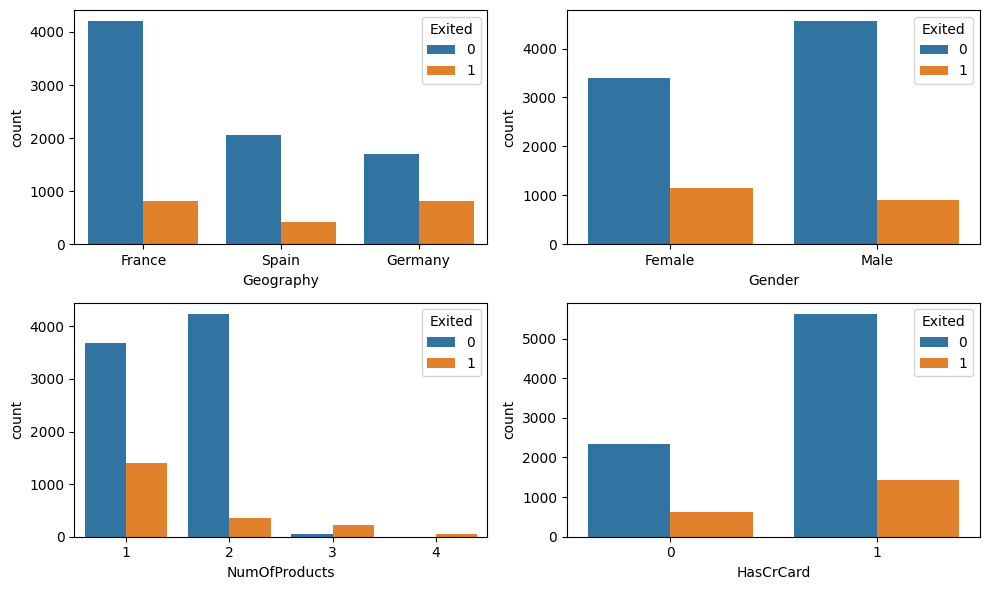

In [10]:
# Check the distribution of the different columns, we will start with the categorical features in this cell.

categorical = df.drop(columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary'])
rows = int(np.ceil(categorical.shape[1] / 2)) - 1

fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10,6))
axes = axes.flatten()

for row in range(rows):
    cols = min(2, categorical.shape[1] - row*2)
    for col in range(cols):
        col_name = categorical.columns[2 * row + col]
        ax = axes[row*2 + col]       

        sns.countplot(data=categorical, x=col_name, hue="Exited", ax=ax);
        
plt.tight_layout()


# of Bivariate Outliers: 19


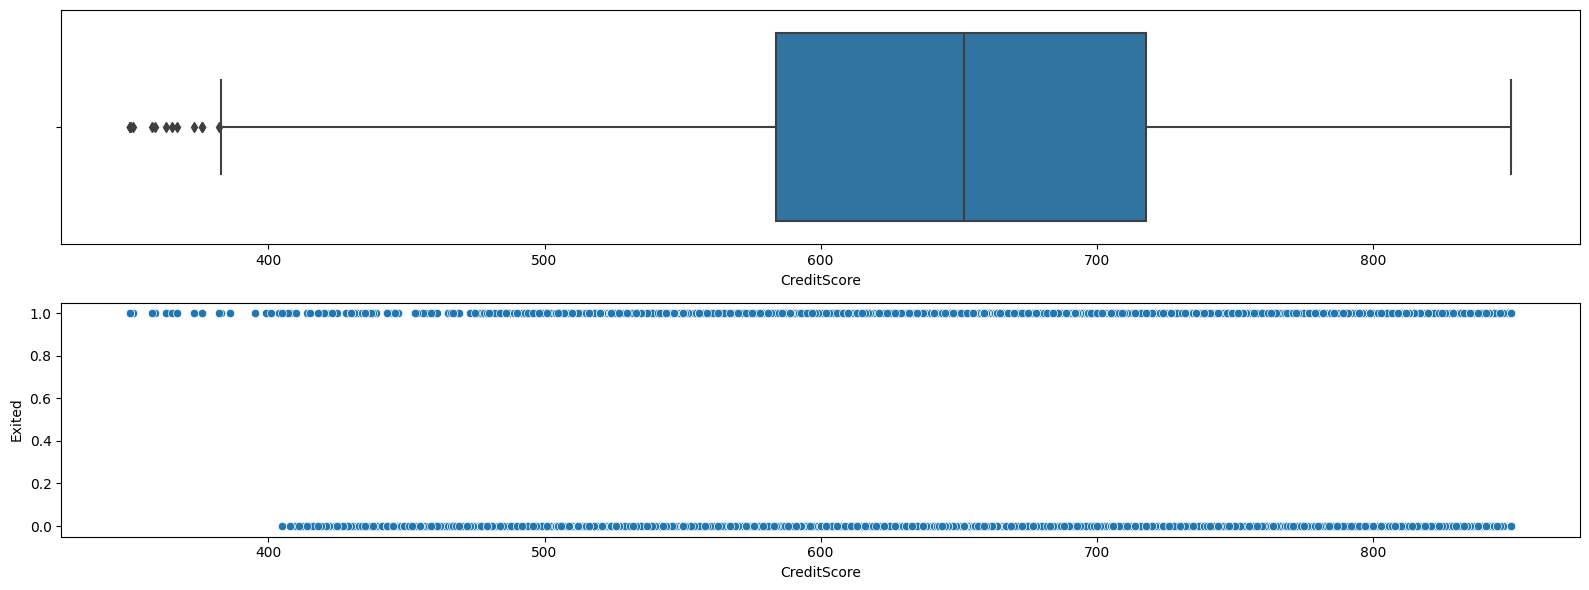

In [11]:
# Check the distribution of the numerical columns

def box_scatter(data, x, y):    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
    sns.boxplot(data=data, x=x, ax=ax1)
    sns.scatterplot(data=data, x=x,y=y,ax=ax2)
    
box_scatter(df,'CreditScore','Exited');
plt.tight_layout()
print(f"# of Bivariate Outliers: {len(df.loc[df['CreditScore'] < 400])}")
df.drop(df[df['CreditScore']<400].index, inplace =True)

# of Bivariate Outliers: 6


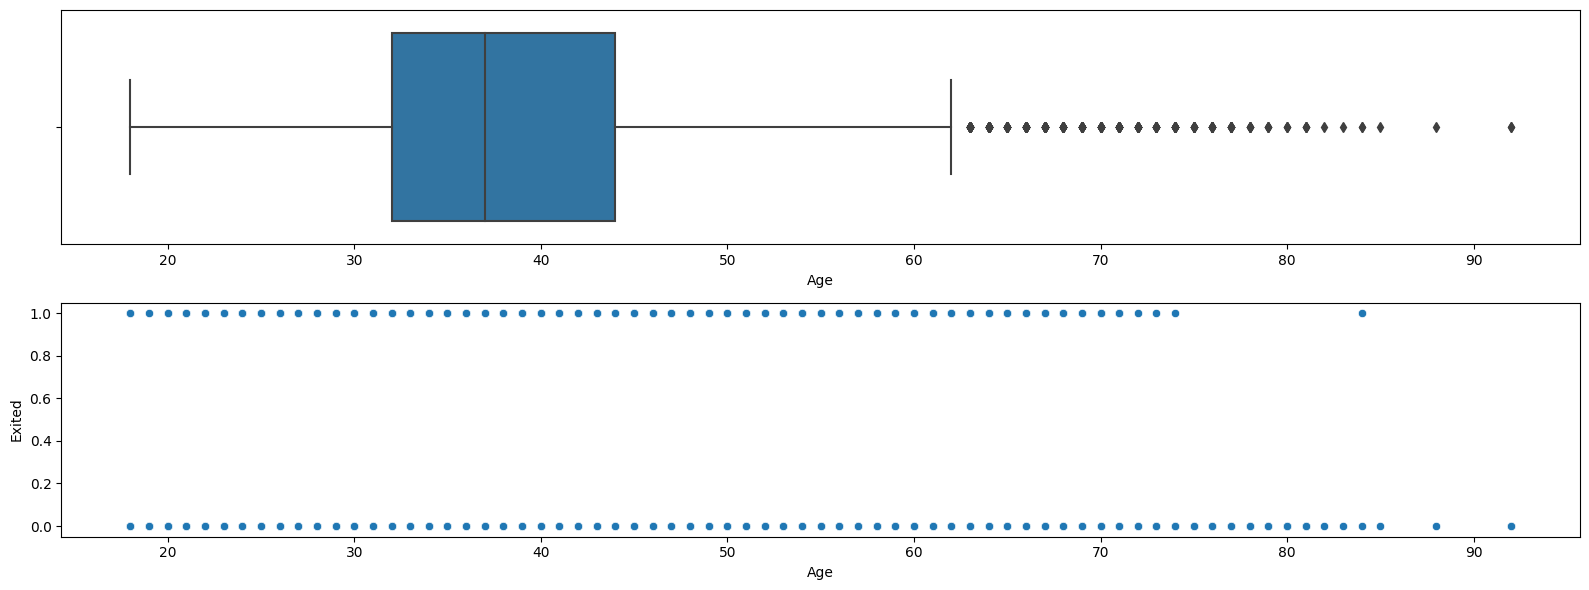

In [12]:
box_scatter(df,'Age','Exited');
plt.tight_layout()
print(f"# of Bivariate Outliers: {len(df.loc[df['Age'] > 83])}")
df.drop(df[df['Age'] > 83].index, inplace =True)

# of Bivariate Outliers: 4


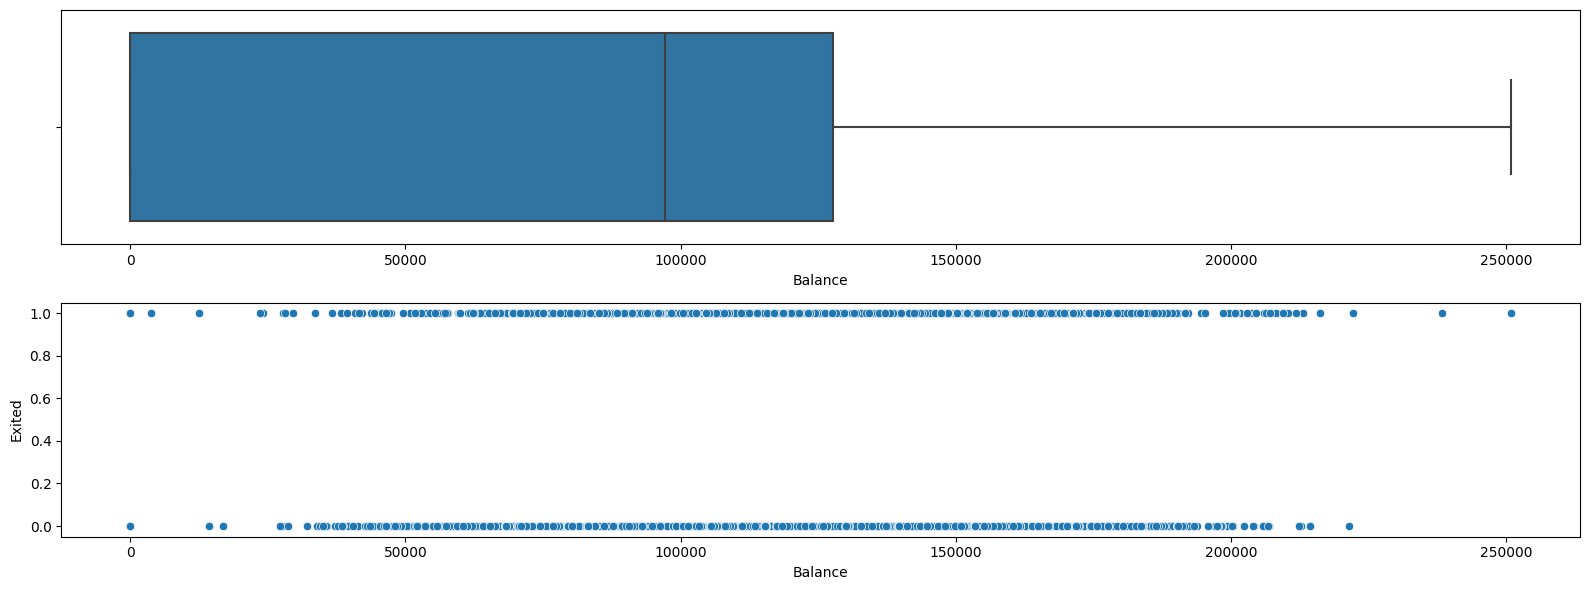

In [13]:
box_scatter(df,'Balance','Exited');
plt.tight_layout()
print(f"# of Bivariate Outliers: {len(df.loc[df['Balance'] > 220000])}")
df.drop(df[df['Balance'] > 220000].index, inplace =True)

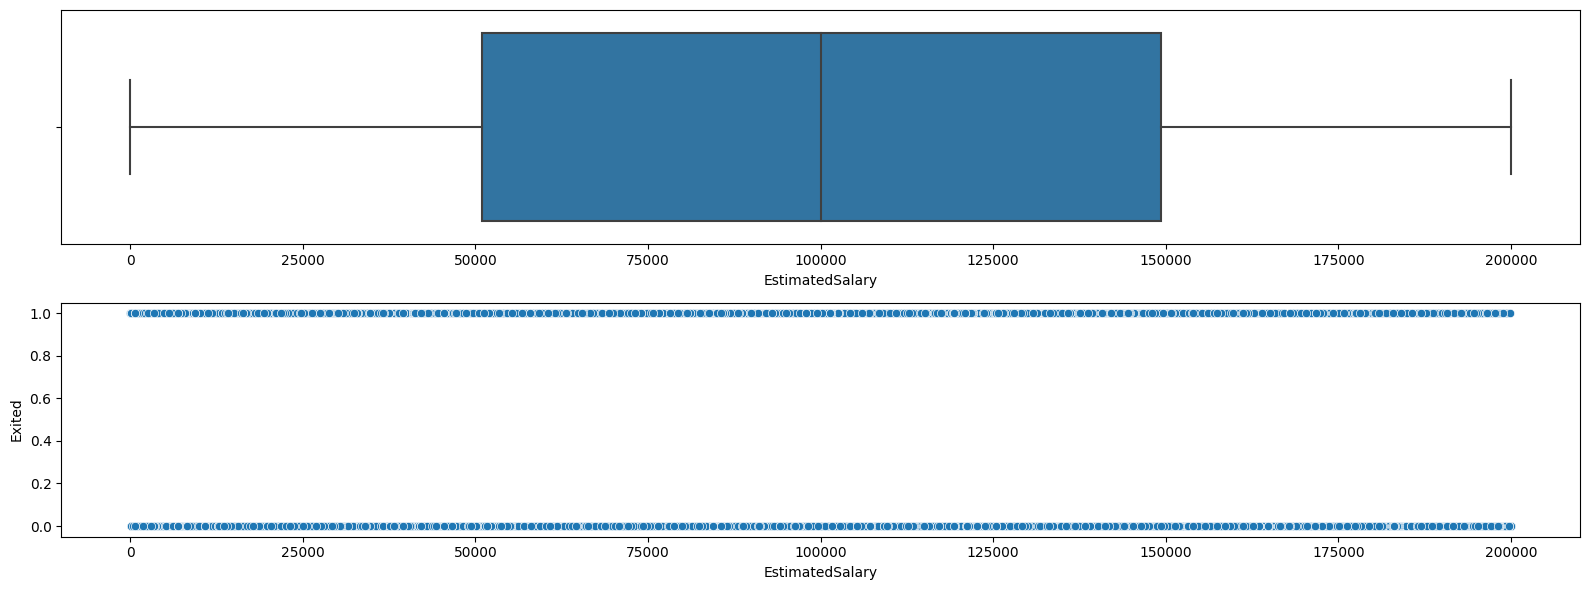

In [14]:
box_scatter(df,'EstimatedSalary','Exited');
plt.tight_layout()

Obervation :

- No missing values
- Contains Skewed variables
- Target is imbalanced
- Contains Outliers
- Contains Categorical variables
- Different scales

Outliers were removed based on values from the scatter and box plots.

In [15]:
# The below functions are needed for analysis purposes

def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

def classification_report_to_dataframe(true, predictions, predictions_proba, model_name, balanced = 'no'):
    a = classification_report(true, predictions, output_dict = True)
    zeros = pd.DataFrame(data = a['0'], index = [0]).iloc[:,0:3].add_suffix('_0')
    ones = pd.DataFrame(data = a['1'], index = [0]).iloc[:,0:3].add_suffix('_1')
    df = pd.concat([zeros, ones], axis = 1)
    temp = list(df)
    df['Model'] = model_name
    df['Balanced'] = balanced
    df['Accuracy'] = accuracy_score(true, predictions)
    df['Balanced_Accuracy'] = balanced_accuracy_score(true, predictions)
    df['AUC'] = roc_auc_score(true, predictions_proba, average = 'macro')
    df = df[['Model', 'Balanced', 'Accuracy', 'Balanced_Accuracy', 'AUC'] + temp]
    return df

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [16]:
exited = len(df[df['Exited'] == 1]['Exited'])
not_exited = len(df[df['Exited'] == 0]['Exited'])
exited_perc = round(exited/len(df)*100,1)
not_exited_perc = round(not_exited/len(df)*100,1)

print('Number of clients that have exited the program: {} ({}%)'.format(exited, exited_perc))
print('Number of clients that haven\'t exited the program: {} ({}%)'.format(not_exited, not_exited_perc))

Number of clients that have exited the program: 2014 (20.2%)
Number of clients that haven't exited the program: 7957 (79.8%)


So, around of 20% of the clients exited the bank, while around 80% stayed. As the goal here is to identify which of the customers are at higher risk to discontinue their services with the bank, we are dealing with a classification problem.

A important point to take into consideration here is that we are dealing with an imbalanced dataset.

In [17]:
gender_count = df['Gender'].value_counts()
gender_pct= gender_count / len(df.index)

gender = pd.concat([gender_count, round(gender_pct,2)], axis=1).set_axis(['count', 'pct'], axis=1)
gender

,count,pct
Gender,,
Male,5442,0.55
Female,4529,0.45


In [18]:
count_by_group(df, feature = 'Gender', target = 'Exited')

,Gender,Exited,count,pct
0,Female,0,3403,75.13800
1,Female,1,1126,24.86200
2,Male,0,4554,83.68247
3,Male,1,888,16.31753


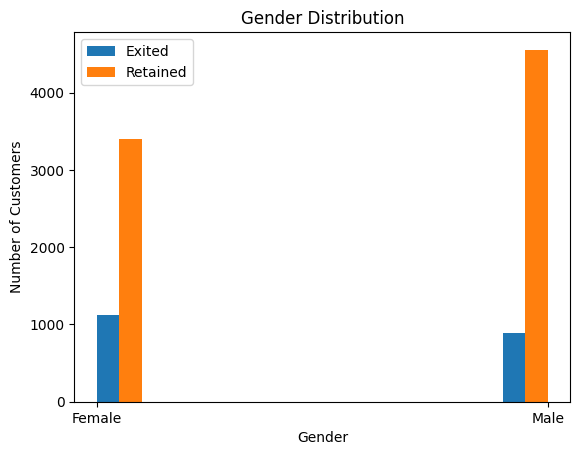

In [19]:
gender_exited = df[df['Exited']==1].Gender  # closed their accounts
gender_retained = df[df['Exited']==0].Gender   # not closed their accounts
plt.hist([gender_exited,gender_retained],rwidth=1.95,label =['Exited','Retained'])
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.title("Gender Distribution")
plt.legend()
plt.show()

In this df, there are more men (55%) than women (45%). Female Customers have a higher tendency to exit and close their accounts compared to male customers.

In [20]:
geo_count = df['Geography'].value_counts()
geo_pct= geo_count / len(df.index)

geo = pd.concat([geo_count, round(geo_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1)
geo

,count,pct
Geography,,
France,5003,0.50
Germany,2502,0.25
Spain,2466,0.25


In [21]:
count_by_group(df, feature = 'Geography', target = 'Exited')


,Geography,Exited,count,pct
0,France,0,4201,83.969618
1,France,1,802,16.030382
2,Germany,0,1694,67.705835
3,Germany,1,808,32.294165
4,Spain,0,2062,83.617194
5,Spain,1,404,16.382806


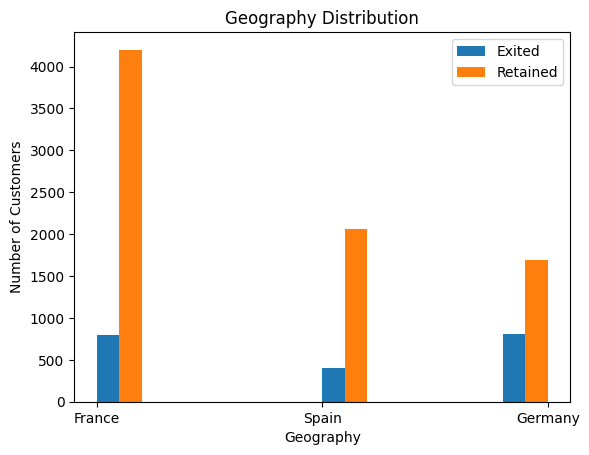

In [22]:
Geography_not_exited = df[df['Exited']==0].Geography
Geography_exited = df[df['Exited']==1].Geography


plt.hist([Geography_exited,Geography_not_exited],rwidth=1.95,label =['Exited','Retained'])
plt.xlabel('Geography')

plt.ylabel('Number of Customers')
plt.title("Geography Distribution")
plt.legend()
plt.show()

The dataset covers 3 countries ; France, Spain, and Germany. Where 50% of the customers are from France and 25% are from Germany, and the other group are from Spain.
Germany has the lowest percentage of retainers , that equals 67% while spain and france have almost the same percentage which is 83%.


In [23]:
HasCrCard_count = df['HasCrCard'].value_counts()
HasCrCard_pct= HasCrCard_count / len(df.index)

HasCrCard = pd.concat([HasCrCard_count, HasCrCard_pct], axis=1).set_axis(['count', 'pct'], axis=1)

HasCrCard

,count,pct
HasCrCard,,
1,7034,0.705446
0,2937,0.294554


In [24]:
count_by_group(df, feature = 'HasCrCard', target = 'Exited')

,HasCrCard,Exited,count,pct
0,0,0,2331,79.366701
1,0,1,606,20.633299
2,1,0,5626,79.982940
3,1,1,1408,20.017060


In [25]:
IsActiveMember_count = df['IsActiveMember'].value_counts()
IsActiveMember_pct= HasCrCard_count / len(df.index)

IsActiveMember = pd.concat([IsActiveMember_count, IsActiveMember_pct], axis=1).set_axis(['count', 'pct'], axis=1)

IsActiveMember

,count,pct
1,5138,0.705446
0,4833,0.294554


In [26]:
count_by_group(df, feature = 'IsActiveMember', target = 'Exited')


,IsActiveMember,Exited,count,pct
0,0,0,3546,73.370577
1,0,1,1287,26.629423
2,1,0,4411,85.850525
3,1,1,727,14.149475


In [27]:
NumOfProducts_count = df['NumOfProducts'].value_counts()
NumOfProducts_pct= NumOfProducts_count / len(df.index)

NumOfProducts = pd.concat([NumOfProducts_count, round(NumOfProducts_pct,2)], axis=1).set_axis(['count', 'pct'], axis=1)
NumOfProducts

,count,pct
NumOfProducts,,
1,5063,0.51
2,4586,0.46
3,263,0.03
4,59,0.01


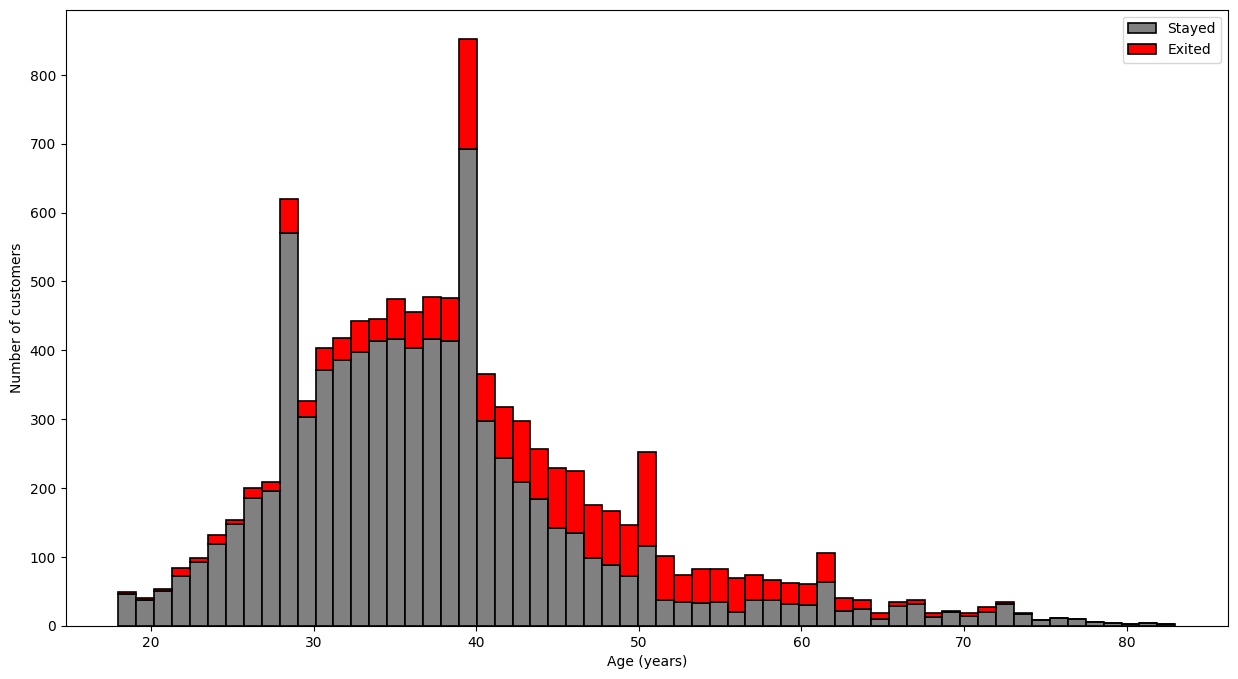

In [28]:
#Stacked histogram: Age
figure = plt.figure(figsize=(15,8))
plt.hist([
        df[(df.Exited==0)]['Age'],
        df[(df.Exited==1)]['Age']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
plt.xlabel('Age (years)')
plt.ylabel('Number of customers')
plt.legend()

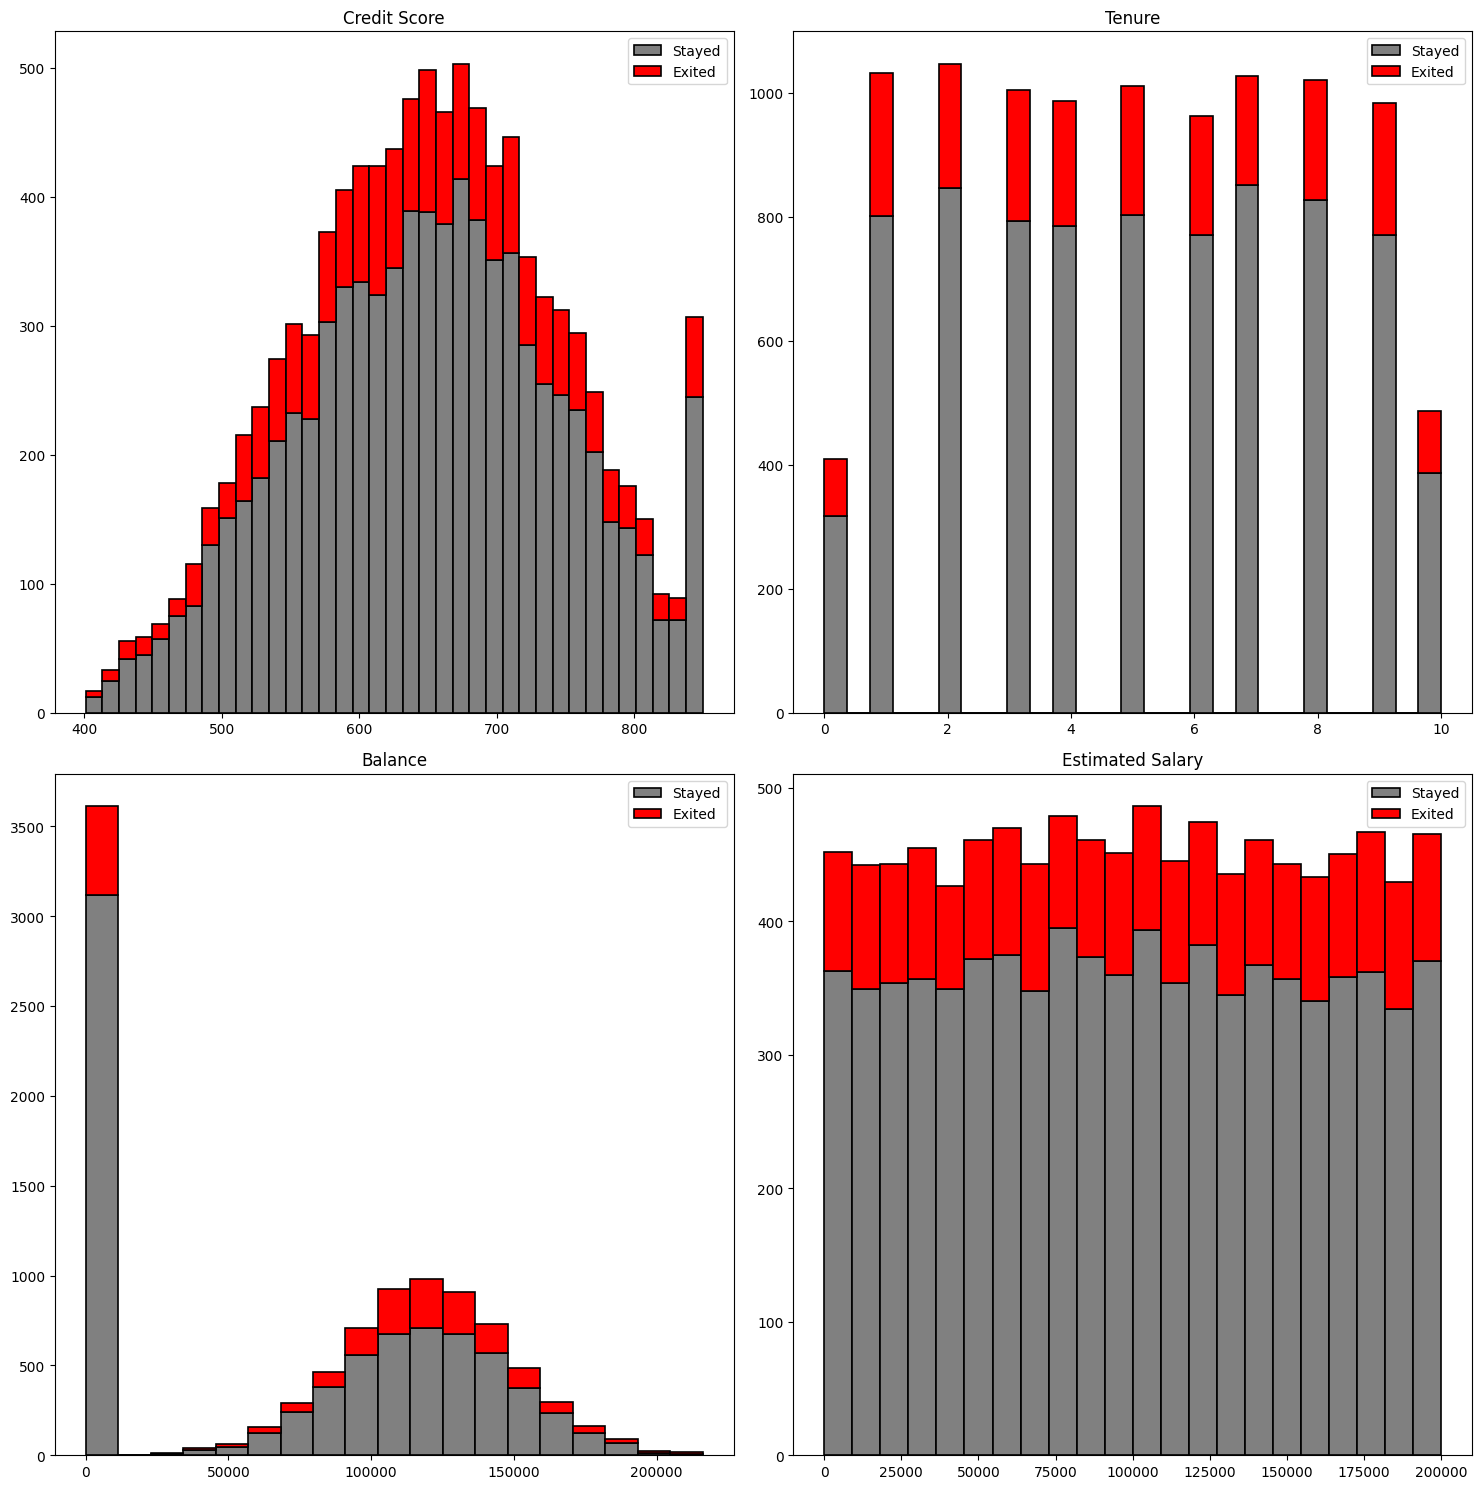

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15,15))
fig.subplots_adjust(left=0.2, wspace=0.6)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist([
        df[(df.Exited==0)]['CreditScore'],
        df[(df.Exited==1)]['CreditScore']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax0.legend()
ax0.set_title('Credit Score')

ax1.hist([
        df[(df.Exited==0)]['Tenure'],
        df[(df.Exited==1)]['Tenure']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax1.legend()
ax1.set_title('Tenure')

ax2.hist([
        df[(df.Exited==0)]['Balance'],
        df[(df.Exited==1)]['Balance']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax2.legend()
ax2.set_title('Balance')

ax3.hist([
        df[(df.Exited==0)]['EstimatedSalary'],
        df[(df.Exited==1)]['EstimatedSalary']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax3.legend()
ax3.set_title('Estimated Salary')

fig.tight_layout()
plt.show()


From the tables and plots above, we can have some insights:

- As for gender, women are lower in number than the men, but have a higher tendendy to churn.
- There is a higher rate of exited clients in Germany (32%, which is about 2x higher), and lower in Spain and France (around 16% each).
- On age, customer bellow 40 and above 65 years old have a tendency to keep their account.
- Has or not credit card does not impact on the decision to stay in the bank (both groups has 20% of exited customers)
- Non active members tend to discontinue their services with a bank compared with the active clients (27% vs 14%).
- The df has 96% of clients with 1 or 2 product, and customers with 1 product only have a higher rate to to close the account than those with 2 products (around 3x higher).
- Estimated Salary does not seem to affect the churn rate.

## Predictive Models
### 1 - Using the unbalanced dataset
#### 1.1 - Logistic Regression Model

In [30]:
# One-Hot encoding our categorical attributes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Geography'] = le.fit_transform(df['Geography'])
df['Gender'] = le.fit_transform(df['Gender'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [31]:
features = list(df.drop('Exited', axis = 1))
target = 'Exited'

In [32]:
train, test = train_test_split(df, test_size = 0.2, random_state = 1)

print('Number of clients in the df: {}'.format(len(df)))
print('Number of clients in the train set: {}'.format(len(train)))
print('Number of clients in the test set: {}'.format(len(test)))

Number of clients in the df: 9971
Number of clients in the train set: 7976
Number of clients in the test set: 1995


In [33]:
exited_train = len(train[train['Exited'] == 1]['Exited'])
exited_train_perc = round(exited_train/len(train)*100,1)

exited_test = len(test[test['Exited'] == 1]['Exited'])
exited_test_perc = round(exited_test/len(test)*100,1)

print('Complete Train set - Number of clients that have exited the program: {} ({}%)'.format(exited_train, exited_train_perc))
print('Test set - Number of clients that haven\'t exited the program: {} ({}%)'.format(exited_test, exited_test_perc))

Complete Train set - Number of clients that have exited the program: 1626 (20.4%)
Test set - Number of clients that haven't exited the program: 388 (19.4%)


The features in the data are of varying magnitudes, and while tree-based models can handle such data without normalization, logistic regression and neural networks (MLP) require data normalization to achieve optimal performance. We are using the standard scaler from sklearn.

In [34]:
#Feature scaling

scaling_cols = ['CreditScore','Age','Tenure','Balance','EstimatedSalary','NumOfProducts']  

sc = StandardScaler()
# fit on training set
train[scaling_cols] = sc.fit_transform(train[scaling_cols])

# only transform on test set
test[scaling_cols] = sc.transform(test[scaling_cols])

To make the initial prediction, we will utilize the Sklearn Logistic Regression model and search for the best parameters by utilizing the GridSearchCV function.

In [35]:
# Let's start with a simple classification model, the classical logistic regression algorithm:
parameters = {'C': [0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150]}
LR = LogisticRegression(penalty = 'l2')
model_LR = GridSearchCV(LR, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(train[features], train[target])
pd.DataFrame(model_LR.cv_results_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.146751,0.074349,0.018586,0.016020,0.01,50,newton-cg,"{'C': 0.01, 'max_iter': 50, 'solver': 'newton-...",0.798872,0.805016,0.796865,0.796238,0.799373,0.799273,0.003103,49
1,0.070474,0.027773,0.013697,0.010256,0.01,50,lbfgs,"{'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}",0.798872,0.805016,0.796865,0.796238,0.799373,0.799273,0.003103,49
2,0.078187,0.025069,0.020865,0.013083,0.01,50,liblinear,"{'C': 0.01, 'max_iter': 50, 'solver': 'libline...",0.805138,0.804389,0.801254,0.803135,0.802508,0.803285,0.001371,46
3,0.102335,0.022426,0.012528,0.011417,0.01,50,sag,"{'C': 0.01, 'max_iter': 50, 'solver': 'sag'}",0.798872,0.805016,0.796865,0.796238,0.799373,0.799273,0.003103,49
4,0.189055,0.065222,0.010798,0.006640,0.01,50,saga,"{'C': 0.01, 'max_iter': 50, 'solver': 'saga'}",0.798872,0.805016,0.796865,0.796238,0.799373,0.799273,0.003103,49
5,0.141196,0.038202,0.012315,0.005343,0.01,100,newton-cg,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.798872,0.805016,0.796865,0.796238,0.799373,0.799273,0.003103,49
6,0.044177,0.010867,0.009503,0.003967,0.01,100,lbfgs,"{'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}",0.798872,0.805016,0.796865,0.796238,0.799373,0.799273,0.003103,49
7,0.060523,0.018103,0.010171,0.004775,0.01,100,liblinear,"{'C': 0.01, 'max_iter': 100, 'solver': 'liblin...",0.805138,0.804389,0.801254,0.803135,0.802508,0.803285,0.001371,46
8,0.109396,0.023122,0.011602,0.006515,0.01,100,sag,"{'C': 0.01, 'max_iter': 100, 'solver': 'sag'}",0.798872,0.805016,0.796865,0.796238,0.799373,0.799273,0.003103,49
9,0.172268,0.057226,0.012385,0.006873,0.01,100,saga,"{'C': 0.01, 'max_iter': 100, 'solver': 'saga'}",0.798872,0.805016,0.796865,0.796238,0.799373,0.799273,0.003103,49


In [36]:
print(model_LR.best_params_)


{'C': 1, 'max_iter': 50, 'solver': 'liblinear'}


Now that we know the "best" parameters for the model, let's do a Recursive Feature Elimination to check the feature importance.

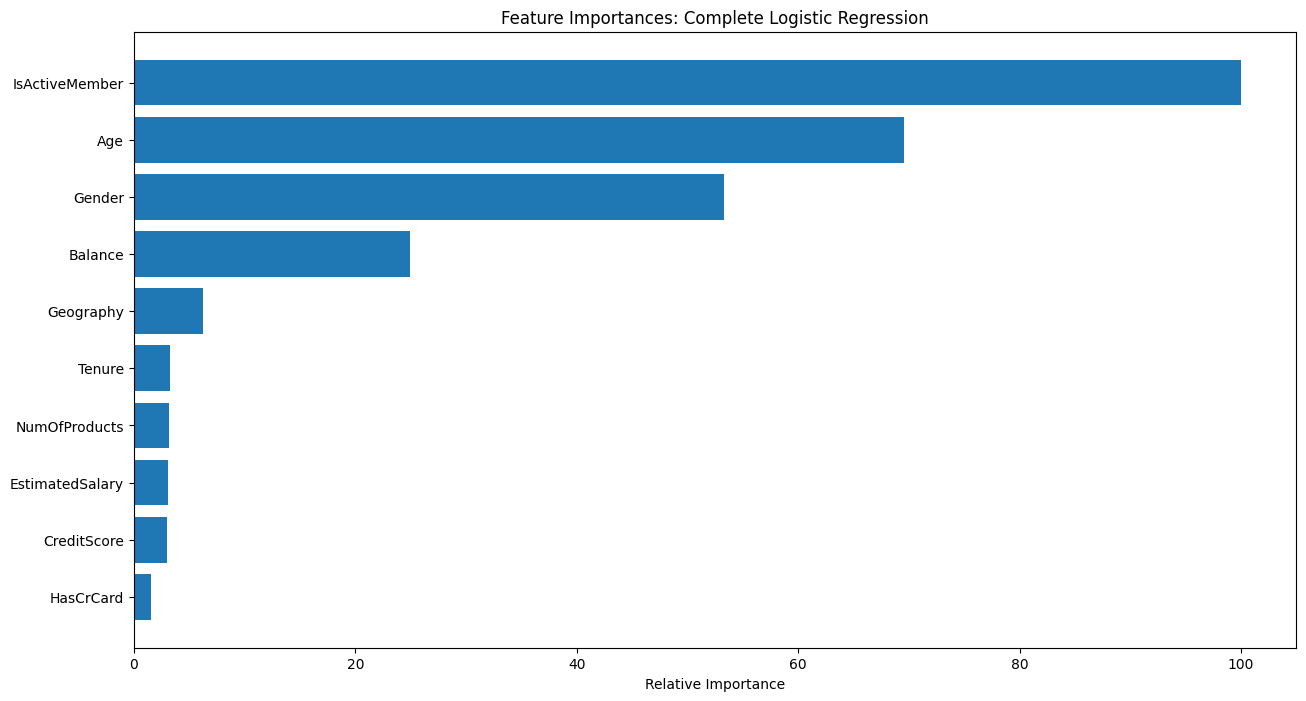

In [37]:
model = LogisticRegression(**model_LR.best_params_)
model.fit(train[features], train[target])

importances = abs(model.coef_[0])
importances = 100.0 * (importances / importances.max())
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Logistic Regression')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Now, let's make the prediction for the test set, for which we know the actual values, in order to evaluate the performance of the model.

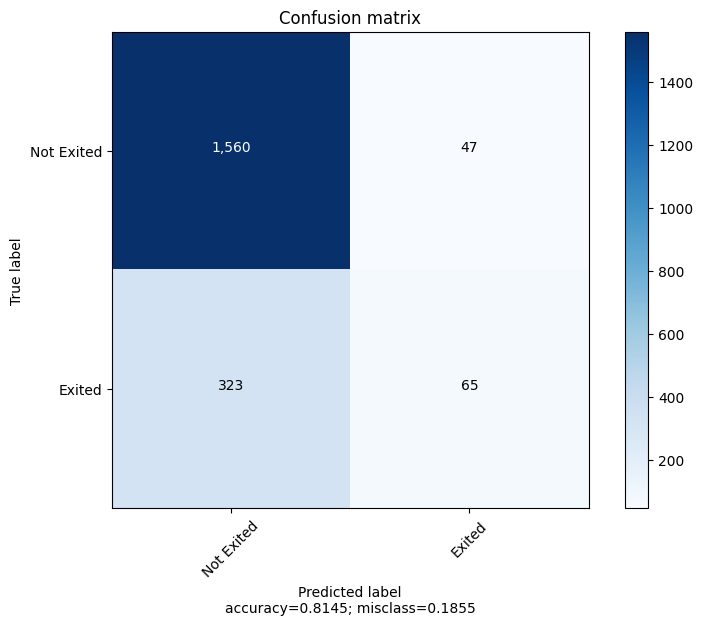

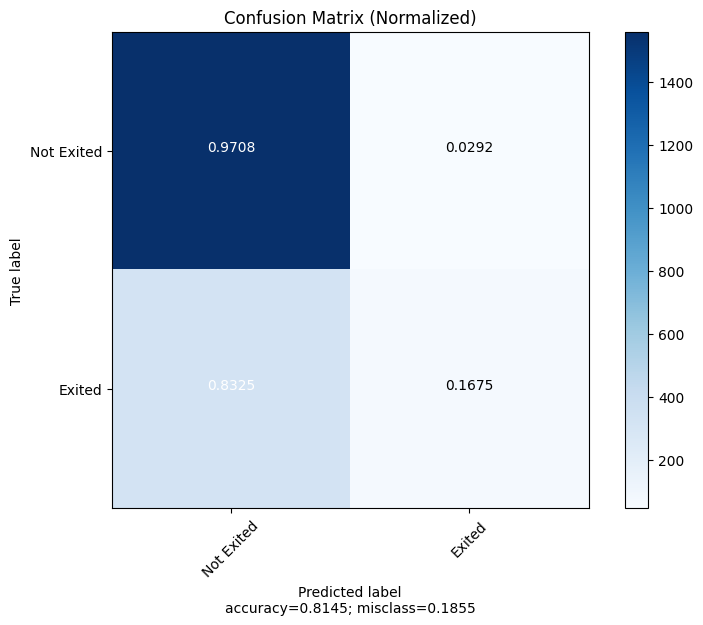

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.814536,0.569139,0.73524,0.828465,0.970753,0.893983,0.580357,0.167526,0.26


In [38]:
pred = model_LR.predict(test[features])
predp = model_LR.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

summary_of_models = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Logistic Regression')
summary_of_models

#### 1.2 - Gradient Boosting Classifier (Sklearn)

In [39]:
parameters = {'max_depth': [2, 3, 4, 6, 10, 15],
              'n_estimators': [50, 100, 300, 500]}
GB = GBSklearn()
model_GB = GridSearchCV(GB, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(train[features], train[target])
pd.DataFrame(model_GB.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.525624,0.531001,0.015301,0.010129,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.863409,0.860815,0.855799,0.859561,0.853292,0.858575,0.003605,13
1,3.336911,0.345780,0.037903,0.019507,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.867168,0.867712,0.856426,0.863323,0.855172,0.861960,0.005268,9
2,7.901086,0.848261,0.028397,0.007924,2,300,"{'max_depth': 2, 'n_estimators': 300}",0.872180,0.872100,0.856426,0.863323,0.857053,0.864217,0.006905,4
3,13.993528,0.731270,0.034154,0.014985,2,500,"{'max_depth': 2, 'n_estimators': 500}",0.874060,0.872100,0.859561,0.860815,0.853918,0.864091,0.007724,6
4,2.130650,0.112116,0.020799,0.008377,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.866541,0.867712,0.859561,0.862069,0.856426,0.862462,0.004224,8
5,3.723534,0.354188,0.015047,0.008147,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.873434,0.870219,0.862069,0.868966,0.858307,0.866599,0.005562,1
6,9.585879,0.322760,0.034187,0.013526,3,300,"{'max_depth': 3, 'n_estimators': 300}",0.870301,0.868339,0.860188,0.865204,0.858307,0.864468,0.004600,3
7,15.267913,0.748987,0.051281,0.012843,3,500,"{'max_depth': 3, 'n_estimators': 500}",0.865288,0.866458,0.855799,0.860815,0.857053,0.861083,0.004261,11
8,1.991909,0.270650,0.014915,0.004795,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.874060,0.865204,0.859561,0.871473,0.858934,0.865847,0.006113,2
9,4.058583,0.491985,0.028311,0.010794,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.875313,0.868966,0.857053,0.862069,0.857680,0.864216,0.006991,5


In [40]:
print(model_GB.best_params_)


{'max_depth': 3, 'n_estimators': 100}


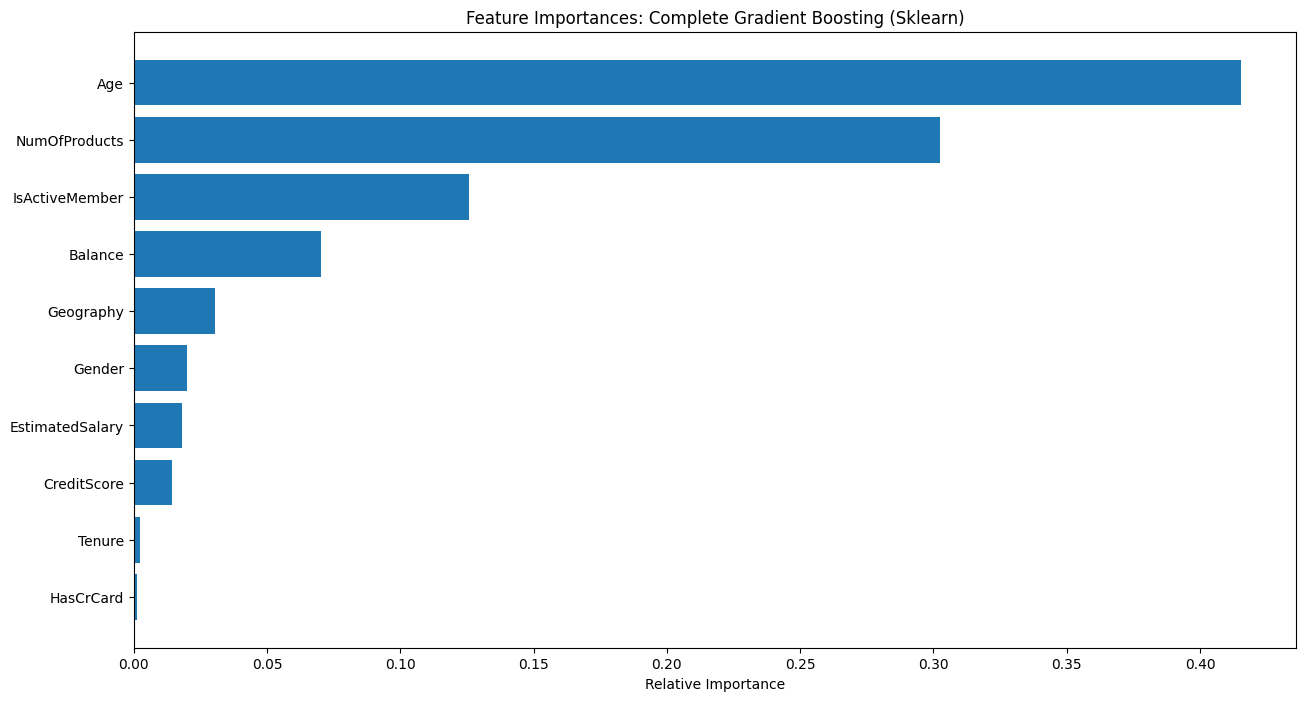

In [41]:
model = GBSklearn(**model_GB.best_params_)
model.fit(train[features], train[target])

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Gradient Boosting (Sklearn)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

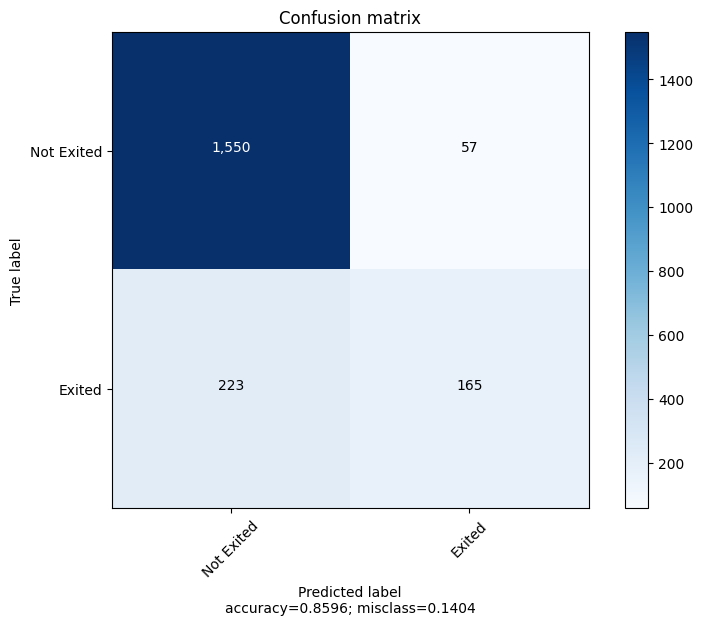

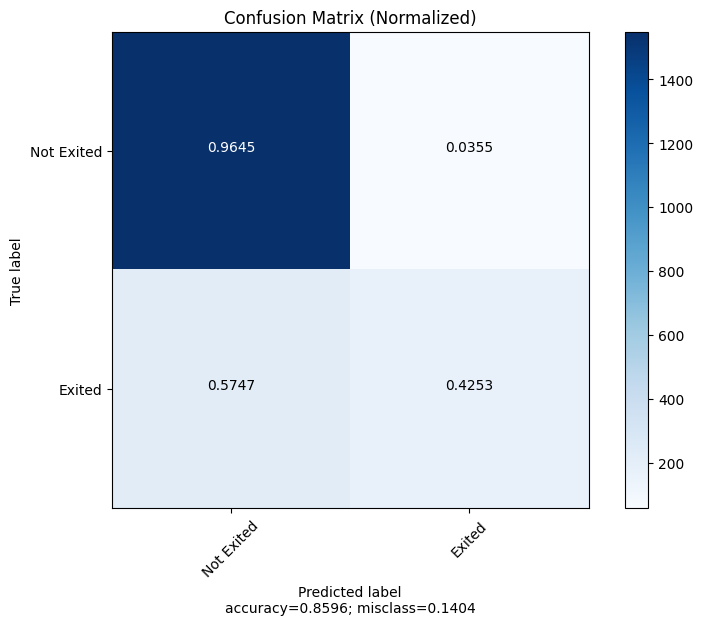

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (Sklearn),no,0.859649,0.694894,0.855345,0.874224,0.96453,0.91716,0.743243,0.425258,0.540984


In [42]:
pred = model_GB.predict(test[features])
predp = model_GB.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (Sklearn)')
temp

In [43]:
summary_of_models = pd.concat([summary_of_models, temp], axis=0)
summary_of_models


,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.814536,0.569139,0.735240,0.828465,0.970753,0.893983,0.580357,0.167526,0.260000
0,Gradient Boosting (Sklearn),no,0.859649,0.694894,0.855345,0.874224,0.964530,0.917160,0.743243,0.425258,0.540984


#### 1.3 - XGBoost Model

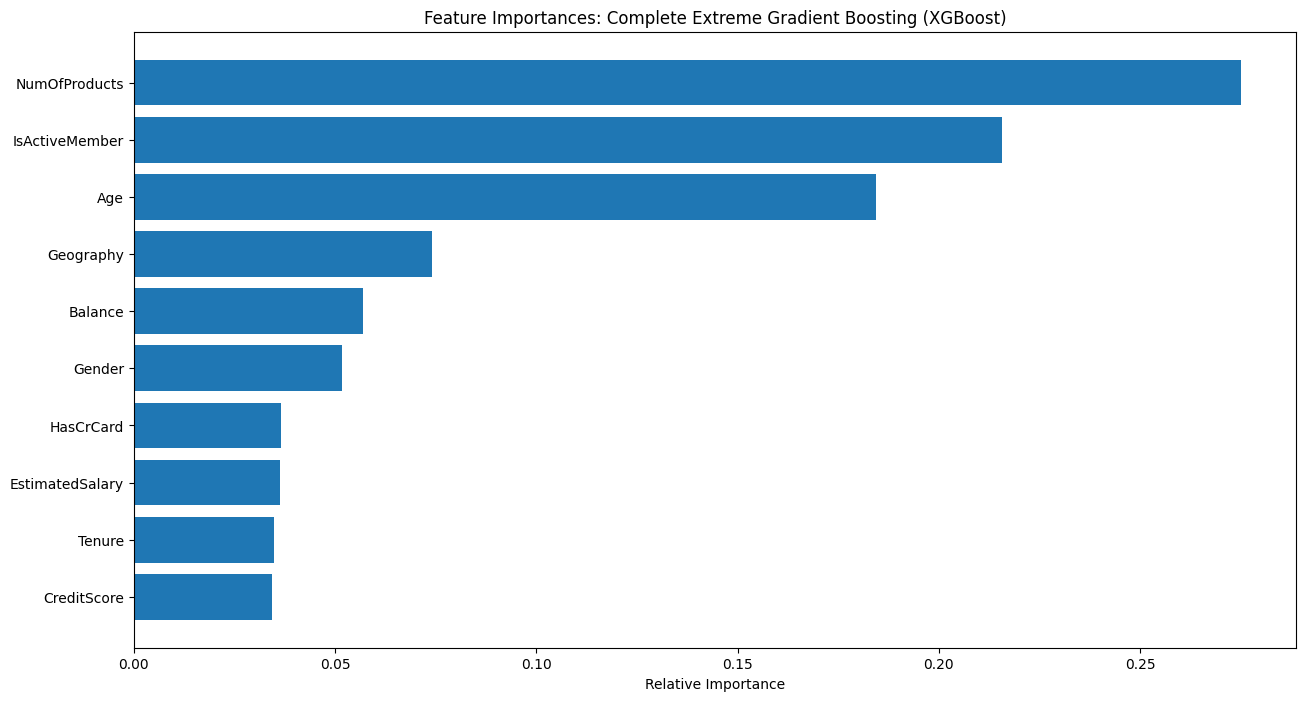

In [44]:

model_XGB = XGB(max_depth = 6,
            learning_rate = .1,
            n_estimators = 100,
            reg_lambda = 0.5,
            reg_alpha = 0,
            verbosity = 1,
            n_jobs = -1,
            tree_method = 'gpu_hist').fit(train[features], train[target])

pred = model_XGB.predict(test[features])
predp = model_XGB.predict_proba(test[features])[:,1]

importances = model_XGB.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Extreme Gradient Boosting (XGBoost)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

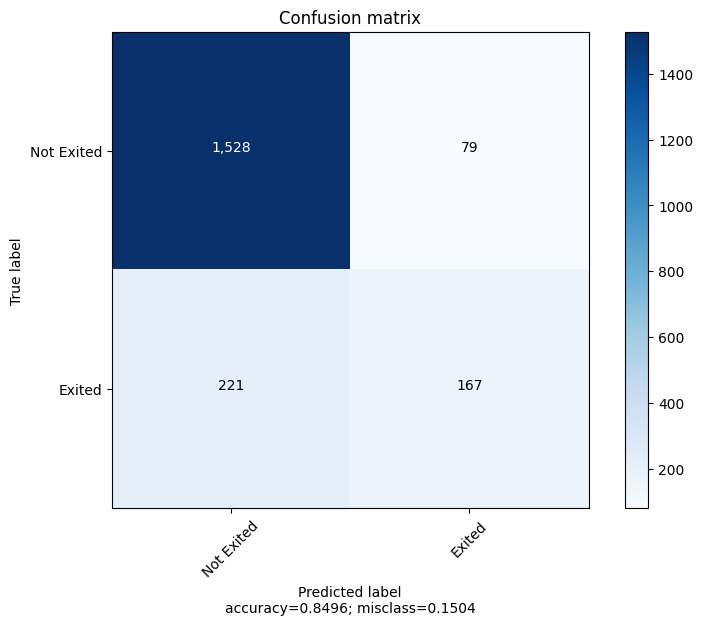

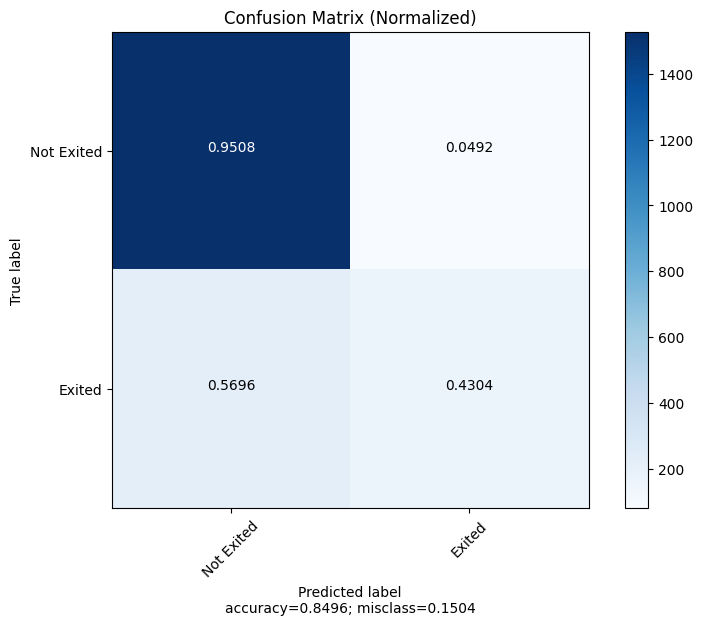

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Gradient Boosting (XGBoost),yes,0.849624,0.690626,0.852724,0.873642,0.95084,0.910608,0.678862,0.430412,0.526814


In [45]:
cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Gradient Boosting (XGBoost)', balanced = 'yes')
temp

In [46]:
summary_of_models = pd.concat([summary_of_models, temp], axis=0)
summary_of_models

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.814536,0.569139,0.735240,0.828465,0.970753,0.893983,0.580357,0.167526,0.260000
0,Gradient Boosting (Sklearn),no,0.859649,0.694894,0.855345,0.874224,0.964530,0.917160,0.743243,0.425258,0.540984
0,Gradient Boosting (XGBoost),yes,0.849624,0.690626,0.852724,0.873642,0.950840,0.910608,0.678862,0.430412,0.526814
